In [1]:
import os
import re

import django
import fs.path
import numpy as np
import pandas as pd
from django.core.exceptions import ObjectDoesNotExist
from fs.osfs import OSFS
from more_itertools import sample

if not os.getcwd().endswith('multidex'):
    os.chdir('..')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "multidex.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

django.setup()

from plotter.models import ZSpec
from multidex_utils import model_metadata_df

In [12]:
for spec in ZSpec.objects.all():
    spec.delete()

In [13]:
[spec.filename for spec in ZSpec.objects.all()]

[]

In [14]:
import os
from pathlib import Path

import django.db.models
import fs
import numpy as np
from fs.osfs import OSFS
import pandas as pd

from ingest.thumbpipe import default_thumbnailer

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "multidex.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

django.setup()

from plotter.models import ZSpec


# TODO: do this better
THUMB_PATH = "static_in_pro/our_static/img/roi_browse/"


def looks_like_marslab(fn):
    if Path(fn).name.endswith("-marslab.csv"):
        return True
    return False


def looks_like_context(fn):
    name = Path(fn).name
    if name.endswith(".png") and ("context" in name):
        return True
    return False


def directory_of(path):
    if path.is_dir():
        return path
    return path.parent


def find_ingest_files(path, recursive=False):
    if recursive:
        tree = OSFS(directory_of(path))
        marslab_files = map(
            tree.getsyspath, filter(looks_like_marslab, tree.walk.files())
        )
        context_files = map(
            tree.getsyspath, filter(looks_like_context, tree.walk.files())
        )
    elif path.is_dir():
        marslab_files = filter(looks_like_marslab, path.iterdir())
        context_files = filter(looks_like_context, path.iterdir())
    else:
        marslab_files = [path]
        context_files = filter(looks_like_context, path.iterdir())
    return marslab_files, context_files


def y_to_bool(df, bool_fields):
    df.loc[:, bool_fields] = df.loc[:, bool_fields] == "Y"


ZCAM_BOOL_FIELDS = [
    field.name.upper()
    for field in ZSpec._meta.fields
    if isinstance(field, django.db.models.fields.BooleanField)
]


def process_context_files(context_files, nailpipe, make_thumbnails=True):
    context_df = pd.DataFrame(context_files, columns=["path"])
    context_df["stem"] = context_df["path"].str.extract(r"(SITE.*).context")
    context_df["eye"] = context_df["path"].str.extract(r"(left|right)")
    if make_thumbnails:
        print("making thumbnails")
        context_df["buffer"] = context_df["path"].apply(nailpipe.execute)
        context_df["save"] = False
    return context_df


def match_obs_images(marslab_file, context_df):
    file_stem = fs.path.split(marslab_file)[-1].replace("-marslab.csv", "")
    context_matches = context_df.loc[
        context_df["stem"] == str(file_stem)
    ]
    context_df.loc[context_matches.index, "save"] = True
    obs_images = {}
    for record in context_matches[["stem", "eye"]].to_dict(orient="records"):
        eye = record["eye"]
        obs_images[eye] = record["stem"] + "-" + eye + "-thumb.jpg"
    return obs_images


USELESS_COLUMNS = ["instrument", "solar_elevation", "roi_source"]


def save_relevant_thumbs(context_df):
    to_save = context_df.loc[context_df["save"] == True]
    thumb_path = THUMB_PATH
    for _, row in to_save.iterrows():
        filename = thumb_path + row["stem"] + "-" + row["eye"] + "-thumb.jpg"
        print("writing " + filename)
        with open(filename, "wb") as file:
            file.write(row["buffer"].getbuffer())


def ingest_multidex(path_or_file, *, recursive: "r" = False):
    """
    ingests zcam -marslab.csv files and context image thumbnails generated
    by asdf into a multidex database. expects all products in an observation
    to have matching filenames -- if you modify the filenames output by
    asdf, this script will likely fail.

    param path_or_file: marslab file or directory containing marslab files.
        looks for matching context images within the same directory.
    param recursive: attempts to ingest all marslab files and context images
        in directory tree, regardless of what specific file you passed it
    """
    path = Path(path_or_file)
    marslab_files, context_files = find_ingest_files(path, recursive)
    context_df = process_context_files(context_files, default_thumbnailer())
    for marslab_file in marslab_files:
        print("ingesting spectra from " + marslab_file)
        obs_images = str(match_obs_images(marslab_file, context_df))
        if obs_images != "{}":
            print("found matching images: " + obs_images)
        else:
            print("no matching images found")
        frame = pd.read_csv(marslab_file)
        y_to_bool(frame, ZCAM_BOOL_FIELDS)
        frame = frame.replace(["-", "", " "], np.nan)
        frame.columns = [col.lower() for col in frame.columns]
        frame = frame[
            [col for col in frame.columns if col not in USELESS_COLUMNS]
        ]
        colors = []
        for _, row in frame.iterrows():
            row = row.dropna()
            for filt in set(ZSpec.filters).intersection(row.index):
                row[filt] = float(row[filt])
            metadata = dict(row) | {
                "filename": fs.path.split(marslab_file)[-1],
                "images": obs_images,
            }
            try:
                spectrum = ZSpec(**metadata)
                spectrum.clean()
                spectrum.save()
                colors.append(row["color"] + " " + row.get("feature"))
            except KeyboardInterrupt:
                raise
            except Exception as ex:
                print("failed on " + row["color"] + ": " + str(ex))
        print("successfully ingested " + ", ".join(colors))
    save_relevant_thumbs(context_df)


In [15]:
path_or_file = "/home/michael/Desktop/asdf_output-20210519T234502Z-001/"
recursive=True

In [16]:
path = Path(path_or_file)
marslab_files, context_files = find_ingest_files(path, recursive)
context_df = process_context_files(context_files, default_thumbnailer())
for marslab_file in marslab_files:
    if '03106' not in marslab_file:
        continue
    print("ingesting spectra from " + marslab_file)
    obs_images = str(match_obs_images(marslab_file, context_df))
    if obs_images != "{}":
        print("found matching images: " + obs_images)
    else:
        print("no matching images found")
    frame = pd.read_csv(marslab_file)
    y_to_bool(frame, ZCAM_BOOL_FIELDS)
    frame = frame.replace(["-", "", " "], np.nan)
    frame.columns = [col.lower() for col in frame.columns]
    frame = frame[
        [col for col in frame.columns if col not in USELESS_COLUMNS]
    ]
    colors = []
    for _, row in frame.iterrows():
        row = row.dropna()
        for filt in set(ZSpec.filters).intersection(row.index):
            row[filt] = float(row[filt])
        metadata = dict(row) | {
            "filename": fs.path.split(marslab_file)[-1],
            "images": obs_images,
        }
        try:
            spectrum = ZSpec(**metadata)
            spectrum.clean()
            spectrum.save()
            colors.append(row["color"] + " " + row.get("feature"))
        except KeyboardInterrupt:
            raise
        except Exception as ex:
            print("failed on " + row["color"] + ": " + str(ex))
    print("successfully ingested " + ", ".join(colors))
# save_relevant_thumbs(context_df)

making thumbnails
ingesting spectra from /home/michael/Desktop/asdf_output-20210519T234502Z-001/asdf_output/marslab-csvs/SITE3_DRIVE1266_RMS44_SOL33_SEQIDzcam03106_ZOOM110-rocks-marslab.csv
found matching images: {'left': 'SITE3_DRIVE1266_RMS44_SOL33_SEQIDzcam03106_ZOOM110-rocks-left-thumb.jpg', 'right': 'SITE3_DRIVE1266_RMS44_SOL33_SEQIDzcam03106_ZOOM110-rocks-right-thumb.jpg'}
successfully ingested azure rock, blue rock, cyan rock, green rock, magenta rock, orange rock, purple rock, red rock
ingesting spectra from /home/michael/Desktop/asdf_output-20210519T234502Z-001/asdf_output/marslab-csvs/SITE3_DRIVE1266_RMS42_SOL33_SEQIDzcam03106_ZOOM110-rocks-marslab.csv
found matching images: {'left': 'SITE3_DRIVE1266_RMS42_SOL33_SEQIDzcam03106_ZOOM110-rocks-left-thumb.jpg', 'right': 'SITE3_DRIVE1266_RMS42_SOL33_SEQIDzcam03106_ZOOM110-rocks-right-thumb.jpg'}
successfully ingested blue rock, cyan rock, green rock, magenta rock, orange rock, purple rock, red rock


In [35]:
save_relevant_thumbs(context_df)

writing static_in_pro/our_static/img/roi_browse/SITE3_DRIVE2430_RMS1180_SOL80_SEQIDzcam03129_ZOOM110-left-thumb.jpg
writing static_in_pro/our_static/img/roi_browse/SITE3_DRIVE2430_RMS1180_SOL80_SEQIDzcam03129_ZOOM110-SRLC-right-thumb.jpg
writing static_in_pro/our_static/img/roi_browse/SITE3_DRIVE2430_RMS1180_SOL80_SEQIDzcam03129_ZOOM110-SRLC-left-thumb.jpg
writing static_in_pro/our_static/img/roi_browse/SITE3_DRIVE2430_RMS1180_SOL80_SEQIDzcam03129_ZOOM110-right-thumb.jpg


In [13]:
sv = context_df.loc[context_df['save'] == True][['stem', 'buffer']]

In [29]:
sv['stem'].iloc[2]

'SITE3_DRIVE2430_RMS1180_SOL80_SEQIDzcam03129_ZOOM110-SRLC'

In [25]:
from PIL import Image

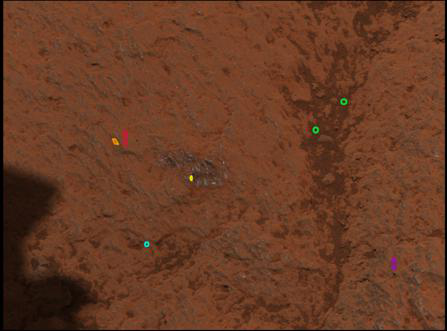

In [33]:
Image.open(
    sv['buffer'].iloc[3]
)